# Description

**FIXME: update**

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "_with_covars"
    / "gene_size_and_log"
    / "gls-debug_use_ols"
)
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_log/gls-debug_use_ols')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"
# PVALUE_COLUMN = "pvalue"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lv = results["lv"].unique()
    assert len(observed_lv) == 1
    observed_lv = observed_lv[0]

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_log/gls-debug_use_ols/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_log/gls-debug_use_ols/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_log/gls-debug_use_ols/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_log/gls-debug_use_ols/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_log/gls-debug_use_ols/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV1,0.006436,0.012468,0.516214,0.605723,0.302861,random.pheno988
1,LV2,0.017628,0.012468,1.413852,0.157454,0.078727,random.pheno988
2,LV3,-0.008124,0.012520,-0.648859,0.516452,0.741774,random.pheno988
3,LV4,-0.010872,0.012571,-0.864884,0.387135,0.806433,random.pheno988
4,LV5,0.003236,0.012470,0.259522,0.795241,0.397621,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.06032725430597771

# Summary of mean type I error per LV

In [18]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [19]:
summary_df.shape

(987, 4)

In [20]:
summary_df.head()

,lv,1,5,10
0,LV1,0.006,0.034,0.061
1,LV10,0.013,0.051,0.084
2,LV100,0.018,0.051,0.099
3,LV101,0.019,0.052,0.098
4,LV102,0.011,0.057,0.102


In [21]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.016638,0.060327,0.108409
std,0.007886,0.015634,0.022104
min,0.002000,0.014000,0.031000
25%,0.012000,0.050000,0.094000
50%,0.016000,0.059000,0.108000
75%,0.020000,0.069000,0.121000
max,0.101000,0.151000,0.216000


## LVs with expected type I error

In [22]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(75, 4)

,lv,1,5,10
344,LV409,0.014,0.049,0.086
285,LV356,0.014,0.049,0.101
609,LV648,0.007,0.049,0.088
345,LV41,0.013,0.049,0.074
348,LV412,0.009,0.049,0.100
388,LV449,0.014,0.049,0.094
397,LV457,0.007,0.049,0.092
462,LV515,0.017,0.049,0.097
828,LV845,0.015,0.049,0.086
948,LV953,0.011,0.049,0.087


,lv,1,5,10
608,LV647,0.010,0.051,0.090
2,LV100,0.018,0.051,0.099
15,LV112,0.013,0.051,0.091
20,LV117,0.010,0.051,0.078
50,LV144,0.012,0.051,0.106
82,LV173,0.012,0.051,0.087
91,LV181,0.016,0.051,0.094
132,LV218,0.015,0.051,0.098
171,LV253,0.013,0.051,0.099
182,LV263,0.012,0.051,0.110


## LVs with high type I error

In [23]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(453, 4)

,lv,1,5,10
199,LV279,0.025,0.095,0.151
213,LV291,0.042,0.098,0.140
796,LV816,0.028,0.100,0.158
28,LV124,0.036,0.100,0.149
382,LV443,0.039,0.101,0.136
663,LV697,0.035,0.101,0.160
99,LV189,0.028,0.102,0.161
961,LV965,0.038,0.104,0.154
142,LV227,0.043,0.104,0.147
167,LV25,0.043,0.105,0.162


# LVs with high mean type I error

In [24]:
lv_results_high = {}

## LV45

In [25]:
lv_code = "LV45"

In [26]:
results = dfs[dfs["lv"] == lv_code]

In [27]:
results.shape

(1000, 7)

In [28]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
44,LV45,0.004891,0.012464,0.392392,0.694782,0.347391,random.pheno988
1031,LV45,0.000834,0.012466,0.066936,0.946635,0.473317,random.pheno589
2018,LV45,-0.000513,0.012462,-0.041160,0.967170,0.516415,random.pheno385
3005,LV45,0.006555,0.012464,0.525917,0.598964,0.299482,random.pheno5
3992,LV45,-0.009499,0.012462,-0.762265,0.445930,0.777035,random.pheno74


In [29]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [30]:
show_prop(results, 0.01)

0.101

In [31]:
show_prop(results, 0.05)

0.151

In [32]:
show_prop(results, 0.10)

0.216

In [33]:
show_prop(results, 0.15)

0.259

In [34]:
show_prop(results, 0.20)

0.29

### QQplot

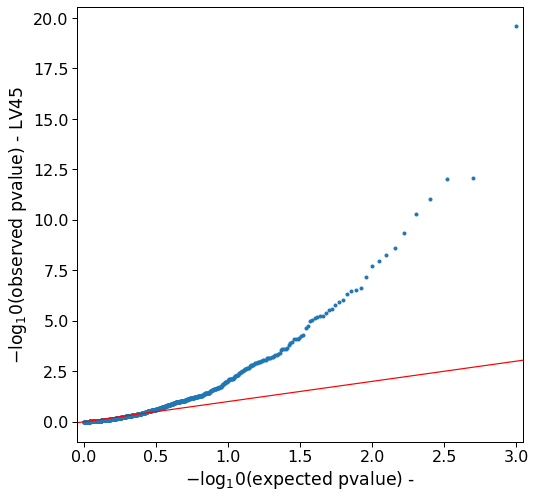

In [35]:
qqplot_unif(results)

## LV234

In [36]:
lv_code = "LV234"

In [37]:
results = dfs[dfs["lv"] == lv_code]

In [38]:
results.shape

(1000, 7)

In [39]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
233,LV234,0.003635,0.012468,0.291543,0.770646,0.385323,random.pheno988
1220,LV234,-0.001765,0.012470,-0.141558,0.887434,0.556283,random.pheno589
2207,LV234,0.001326,0.012466,0.106358,0.915302,0.457651,random.pheno385
3194,LV234,0.012135,0.012467,0.973361,0.330410,0.165205,random.pheno5
4181,LV234,0.011122,0.012466,0.892175,0.372332,0.186166,random.pheno74


In [40]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [41]:
show_prop(results, 0.01)

0.085

In [42]:
show_prop(results, 0.05)

0.149

In [43]:
show_prop(results, 0.10)

0.203

In [44]:
show_prop(results, 0.15)

0.235

In [45]:
show_prop(results, 0.20)

0.279

### QQplot

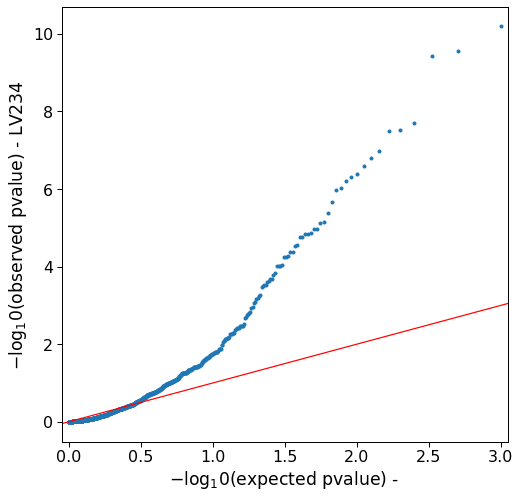

In [46]:
qqplot_unif(results)

## LV847

In [47]:
lv_code = "LV847"

In [48]:
results = dfs[dfs["lv"] == lv_code]

In [49]:
results.shape

(1000, 7)

In [50]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
846,LV847,-0.005095,0.012472,-0.408543,0.682888,0.658556,random.pheno988
1833,LV847,0.000963,0.012473,0.077197,0.938469,0.469235,random.pheno589
2820,LV847,-0.004256,0.012470,-0.341332,0.732865,0.633568,random.pheno385
3807,LV847,0.007333,0.012471,0.588008,0.556547,0.278274,random.pheno5
4794,LV847,0.013874,0.012469,1.112695,0.265881,0.132940,random.pheno74


In [51]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [52]:
show_prop(results, 0.01)

0.087

In [53]:
show_prop(results, 0.05)

0.139

In [54]:
show_prop(results, 0.10)

0.185

In [55]:
show_prop(results, 0.15)

0.219

In [56]:
show_prop(results, 0.20)

0.253

### QQplot

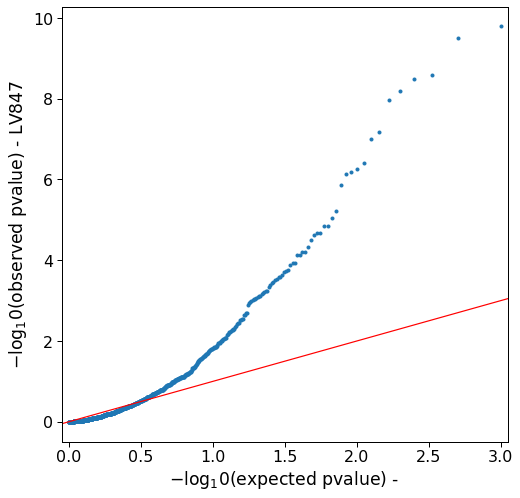

In [57]:
qqplot_unif(results)

## LV110

In [58]:
lv_code = "LV110"

In [59]:
results = dfs[dfs["lv"] == lv_code]

In [60]:
results.shape

(1000, 7)

In [61]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
109,LV110,-0.025194,0.012471,-2.020133,0.043411,0.978295,random.pheno988
1096,LV110,0.000290,0.012477,0.023245,0.981456,0.490728,random.pheno589
2083,LV110,-0.006003,0.012473,-0.481291,0.630326,0.684837,random.pheno385
3070,LV110,-0.006962,0.012475,-0.558105,0.576792,0.711604,random.pheno5
4057,LV110,0.008917,0.012473,0.714863,0.474720,0.237360,random.pheno74


In [62]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [63]:
show_prop(results, 0.01)

0.073

In [64]:
show_prop(results, 0.05)

0.122

In [65]:
show_prop(results, 0.10)

0.166

In [66]:
show_prop(results, 0.15)

0.208

In [67]:
show_prop(results, 0.20)

0.24

### QQplot

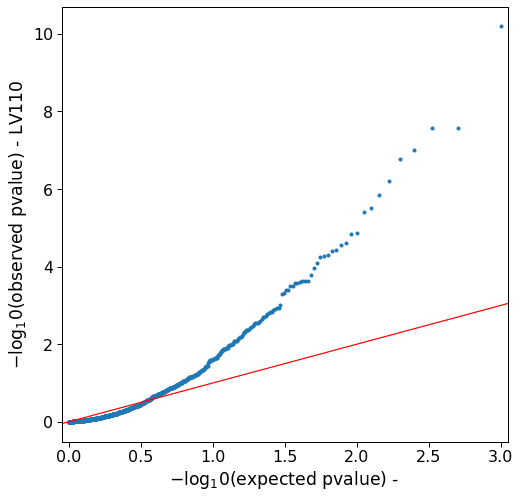

In [68]:
qqplot_unif(results)

## LV769

In [69]:
lv_code = "LV769"

In [70]:
results = dfs[dfs["lv"] == lv_code]

In [71]:
results.shape

(1000, 7)

In [72]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
768,LV769,0.012282,0.012458,0.985864,0.324237,0.162118,random.pheno988
1755,LV769,0.001459,0.012461,0.117095,0.906789,0.453394,random.pheno589
2742,LV769,0.001840,0.012457,0.147732,0.882559,0.441279,random.pheno385
3729,LV769,-0.021244,0.012456,-1.705481,0.088153,0.955923,random.pheno5
4716,LV769,-0.019005,0.012456,-1.525827,0.127102,0.936449,random.pheno74


In [73]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [74]:
show_prop(results, 0.01)

0.038

In [75]:
show_prop(results, 0.05)

0.12

In [76]:
show_prop(results, 0.10)

0.198

In [77]:
show_prop(results, 0.15)

0.249

In [78]:
show_prop(results, 0.20)

0.303

### QQplot

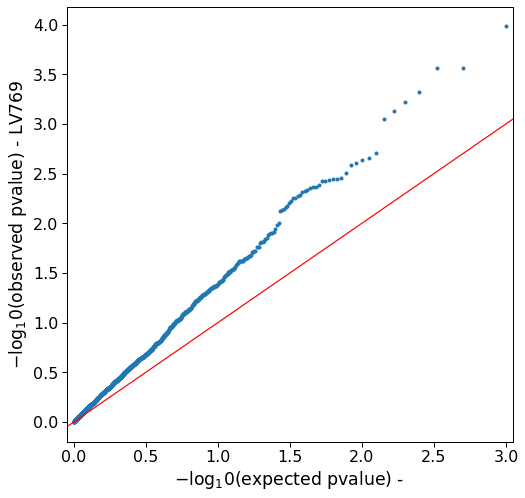

In [79]:
qqplot_unif(results)

## LV800

In [80]:
lv_code = "LV800"

In [81]:
results = dfs[dfs["lv"] == lv_code]

In [82]:
results.shape

(1000, 7)

In [83]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
799,LV800,0.010858,0.012471,0.870706,0.383947,0.191974,random.pheno988
1786,LV800,0.002827,0.012473,0.226683,0.820677,0.410339,random.pheno589
2773,LV800,-0.011377,0.012469,-0.912489,0.361546,0.819227,random.pheno385
3760,LV800,-0.022412,0.012468,-1.797571,0.072292,0.963854,random.pheno5
4747,LV800,-0.009242,0.012469,-0.741213,0.458592,0.770704,random.pheno74


In [84]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [85]:
show_prop(results, 0.01)

0.048

In [86]:
show_prop(results, 0.05)

0.112

In [87]:
show_prop(results, 0.10)

0.179

In [88]:
show_prop(results, 0.15)

0.214

In [89]:
show_prop(results, 0.20)

0.257

### QQplot

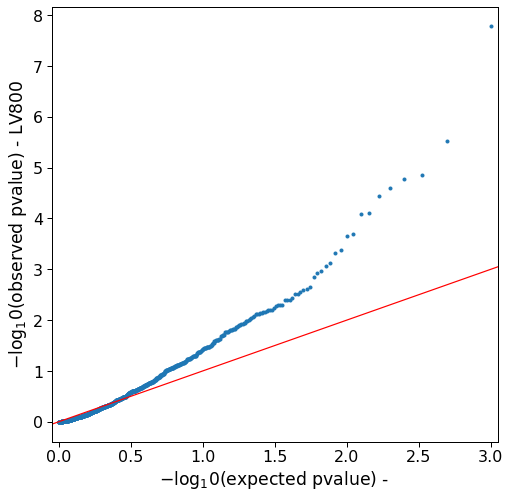

In [90]:
qqplot_unif(results)

# LVs with expected mean type I error

In [91]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
344,LV409,0.014,0.049,0.086
285,LV356,0.014,0.049,0.101
609,LV648,0.007,0.049,0.088
345,LV41,0.013,0.049,0.074
348,LV412,0.009,0.049,0.100
388,LV449,0.014,0.049,0.094
397,LV457,0.007,0.049,0.092
462,LV515,0.017,0.049,0.097
828,LV845,0.015,0.049,0.086
948,LV953,0.011,0.049,0.087


In [92]:
lv_results_expected = {}

## LV412

In [93]:
lv_code = "LV412"

In [94]:
results = dfs[dfs["lv"] == lv_code]

In [95]:
results.shape

(1000, 7)

In [96]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
411,LV412,-0.010498,0.012459,-0.842581,0.399494,0.800253,random.pheno988
1398,LV412,-0.015930,0.012460,-1.278508,0.201116,0.899442,random.pheno589
2385,LV412,0.019376,0.012455,1.555619,0.119848,0.059924,random.pheno385
3372,LV412,0.009599,0.012459,0.770496,0.441034,0.220517,random.pheno5
4359,LV412,0.010109,0.012457,0.811507,0.417104,0.208552,random.pheno74


In [97]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [98]:
show_prop(results, 0.01)

0.009

In [99]:
show_prop(results, 0.05)

0.049

In [100]:
show_prop(results, 0.10)

0.1

In [101]:
show_prop(results, 0.15)

0.141

In [102]:
show_prop(results, 0.20)

0.188

### QQplot

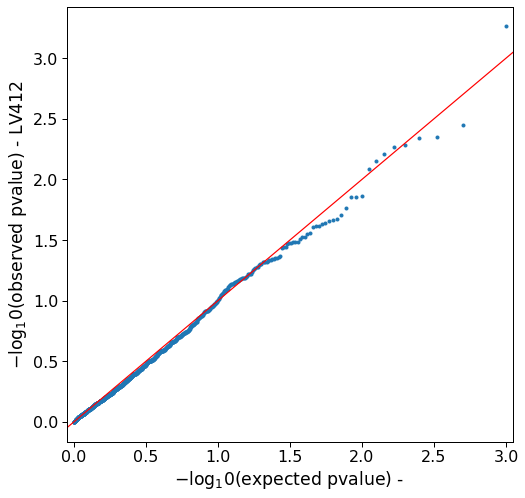

In [103]:
qqplot_unif(results)

## LV57

In [104]:
lv_code = "LV57"

In [105]:
results = dfs[dfs["lv"] == lv_code]

In [106]:
results.shape

(1000, 7)

In [107]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
56,LV57,-0.020311,0.012460,-1.630114,0.103126,0.948437,random.pheno988
1043,LV57,0.023591,0.012461,1.893174,0.058380,0.029190,random.pheno589
2030,LV57,0.014725,0.012459,1.181864,0.237303,0.118652,random.pheno385
3017,LV57,-0.003969,0.012462,-0.318496,0.750119,0.624940,random.pheno5
4004,LV57,0.013952,0.012460,1.119723,0.262874,0.131437,random.pheno74


In [108]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [109]:
show_prop(results, 0.01)

0.012

In [110]:
show_prop(results, 0.05)

0.049

In [111]:
show_prop(results, 0.10)

0.092

In [112]:
show_prop(results, 0.15)

0.135

In [113]:
show_prop(results, 0.20)

0.182

### QQplot

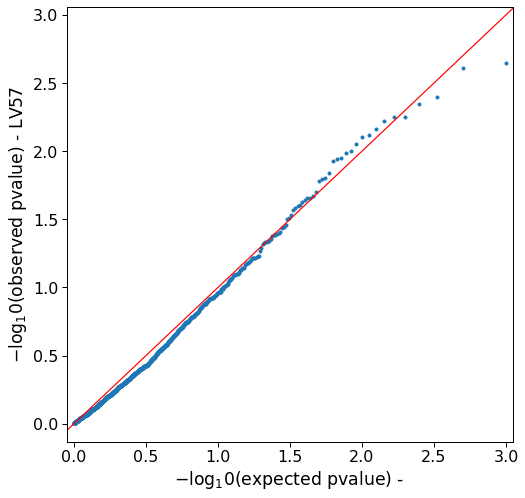

In [114]:
qqplot_unif(results)

## LV647

In [115]:
lv_code = "LV647"

In [116]:
results = dfs[dfs["lv"] == lv_code]

In [117]:
results.shape

(1000, 7)

In [118]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
646,LV647,-0.007630,0.012473,-0.611745,0.540728,0.729636,random.pheno988
1633,LV647,0.000598,0.012475,0.047970,0.961741,0.480871,random.pheno589
2620,LV647,0.000349,0.012472,0.027962,0.977693,0.488847,random.pheno385
3607,LV647,0.004976,0.012473,0.398946,0.689946,0.344973,random.pheno5
4594,LV647,0.004897,0.012472,0.392652,0.694590,0.347295,random.pheno74


In [119]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [120]:
show_prop(results, 0.01)

0.01

In [121]:
show_prop(results, 0.05)

0.051

In [122]:
show_prop(results, 0.10)

0.09

In [123]:
show_prop(results, 0.15)

0.145

In [124]:
show_prop(results, 0.20)

0.183

### QQplot

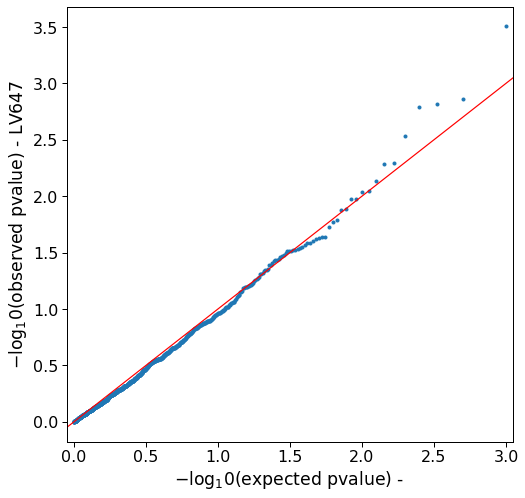

In [125]:
qqplot_unif(results)